In [542]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess

In [314]:
def psql_dict(data,keys):
    return dict((key,data[key]) for key in keys)

def load_psql_file(fn,str_kws=[]):
    '''str_kws is list of column names of type string, all other col names assumed to be float'''
    fin=open(fn,'r')
    keys=fin.readline()
    fin.close()
    keys= keys.split('|')
    for i in range(len(keys)): keys[i]= keys[i].strip()
    print 'keys= ',keys
    dtype=dict(formats=['f4']*len(keys), names=keys)  #holds more than 4 decimals
    #change str_kws to type string
    for kw in str_kws: dtype['formats'][keys.index(kw)]= 'S4' #length 4 strings
    #only tuples to np.loadtxt
    for k in dtype.keys(): dtype[k]= tuple(dtype[k])
    #load everything
    data= np.loadtxt(fn,skiprows=2,delimiter='|',dtype=dtype)
    # #make data a dictionary
    return psql_dict(data,keys)

In [444]:
m_gal= load_psql_file('../truth_table_results/deep2_f2_matched_galaxy.txt',str_kws=['type'])
m_star= load_psql_file('../truth_table_results/deep2_f2_matched_star.txt',str_kws=['type'])
un_gal= load_psql_file('../truth_table_results/deep2_f2_unmatched_galaxy.txt')
un_star= load_psql_file('../truth_table_results/deep2_f2_unmatched_star.txt')
assert( (m_gal['dp_ra'] - m_gal['dr2_ra']).max() < 1e-3)
assert( (m_gal['dp_dec'] - m_gal['dr2_dec']).max() < 1e-3)
assert( (m_star['dp_ra'] - m_star['dr2_ra']).max() < 1e-3)
assert( (m_star['dp_dec'] - m_star['dr2_dec']).max() < 1e-3)

keys=  ['dp_ra', 'dp_dec', 'dr2_ra', 'dr2_dec', 'zhelio', 'bestb', 'bestr', 'besti', 'gflux', 'rflux', 'zflux', 'w1flux', 'w2flux', 'g_ext', 'r_ext', 'z_ext', 'w1_ext', 'w2_ext', 'type']
keys=  ['dp_ra', 'dp_dec', 'dr2_ra', 'dr2_dec', 'zhelio', 'bestb', 'bestr', 'besti', 'gflux', 'rflux', 'zflux', 'w1flux', 'w2flux', 'g_ext', 'r_ext', 'z_ext', 'w1_ext', 'w2_ext', 'type']
keys=  ['ra', 'dec', 'zhelio', 'bestb', 'bestr', 'besti']
keys=  ['ra', 'dec', 'zhelio', 'bestb', 'bestr', 'besti']


In [515]:
def cut_neg_fluxes(data):
    ind= np.all((data['gflux']>0,data['rflux']>0, data['zflux']>0,data['w1flux']>0,data['w2flux']>0), axis=0)
    for key in data.keys(): data[key]= data[key][ind]

def flux_w_ext(data):
    for b in ['g', 'r', 'z','w1','w2']:
        data[b+'flux_ext']= data[b+'flux']/data[b+'_ext']

def flux_to_mag_ab(data):
    for b in ['g', 'r', 'z','w1','w2']:
        data[b+'mag']= 22.5 -2.5*np.log10(data[b+'flux_ext'])
        
def BGS_cuts(data):
    data['bgs']= np.all((data['type'] != 'PSF ',\
                         data['rmag']<19.35),\
                        axis=0)

def LRG_cuts(data):
    data['lrg']= np.all((data['rmag']<23.0,\
                       data['zmag']<20.56,\
                       data['w1mag']<19.35,\
                       data['rmag']-data['zmag']> 1.6,\
                       data['rmag']-data['w1mag']> 1.33*(data['rmag']-data['zmag']) -0.33),\
                        axis=0)

def ELG_cuts(data):
    data['elg']= np.all((data['rmag']<23.4,\
                       data['rmag']-data['zmag']> 0.3,\
                        data['rmag']-data['zmag']< 1.5,\
                       data['gmag']-data['rmag']< 1.0*(data['rmag']-data['zmag']) -0.2,\
                        data['gmag']-data['rmag']< -1.0*(data['rmag']-data['zmag']) +1.2),\
                        axis=0)

def QSO_cuts(data):
    wavg= 0.75*data['w1mag']+ 0.25*data['w2mag']
    data['qso']= np.all((data['type']=='PSF ',\
                        data['rmag']<23.0,
                       data['gmag']-data['rmag']< 1.0,\
                        data['rmag']-data['zmag']> -0.3,\
                       data['rmag']-data['zmag']< 1.1,\
                        data['rmag']-wavg> 1.2*(data['gmag']-data['rmag']) -0.4),\
                        axis=0)

def get_targets(data):
    cut_neg_fluxes(data)
    flux_w_ext(data)
    flux_to_mag_ab(data)
    #indices for each class
    BGS_cuts(data)
    LRG_cuts(data)
    ELG_cuts(data)
    QSO_cuts(data)
    data['non_ptsrc']= np.any((data['qso'],data['lrg'],data['bgs'],data['elg']), axis=0)
    data['ptsrc']= data['non_ptsrc'] == False



In [499]:

# \
#                        data['zmag']<20.56,\
#                        data['w1mag']<19.35,\
#                        data['rmag']-data['zmag']> 1.6,\
#                        data['rmag']-data['w1mag']> 1.33*(data['rmag']-data['zmag']) -0.33),\
#                         axis=0)
a=[False,False,True]
b=[True,False,False]
c=[False,True,True]
d= np.any((a,b,c),axis=0)
d == False

array([False, False, False], dtype=bool)

In [257]:
dat['zhelio'][dat['elg']]

array([ 0.50172698,  0.97452301,  0.89871001,  1.05328   ,  1.33410001,
        1.28351998,  0.99748403,  0.98006701,  2.09682012,  1.16363001,
        1.11034   ,  0.844814  ,  0.96263301,  1.11342001,  0.90312898,
        1.23327005,  0.82872403,  1.33039999,  1.03795004,  1.12434995,
        1.27366996,  0.79148299,  0.75993699,  1.32264996,  1.00803006,
        1.19379997,  0.841245  ,  1.04269004,  0.78568399,  0.77584898,
        1.27040005,  0.967897  ,  0.76860702,  0.73080802,  1.12190998,
        0.803518  ,  1.98473001,  0.86497903,  0.78990602,  0.95128202,
        1.08097994,  0.79636401,  1.66356003,  1.35900998,  1.4562    ,
        1.89064002,  1.23801994,  1.03161001,  0.945912  ,  1.23062003,
        0.77931398,  1.27168   ], dtype=float32)

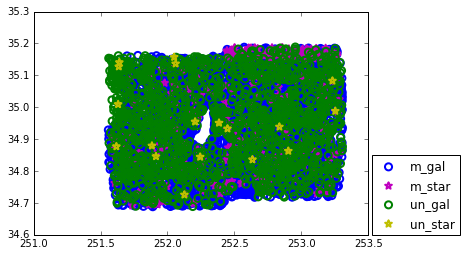

In [445]:
kwargs=dict(s=50,facecolors='none',linewidths=2.)
plt.scatter(m_gal['dr2_ra'],m_gal['dr2_dec'],edgecolors='b',label='m_gal',marker='o',**kwargs)
plt.scatter(m_star['dr2_ra'],m_star['dr2_dec'],edgecolors='m',label='m_star',marker='*',**kwargs)
plt.scatter(un_gal['ra'],un_gal['dec'],edgecolors='g',label='un_gal',marker='o',**kwargs)
plt.scatter(un_star['ra'],un_star['dec'],edgecolors='y',label='un_star',marker='*',**kwargs)
plt.legend(loc=(1.01,0),scatterpoints=1)

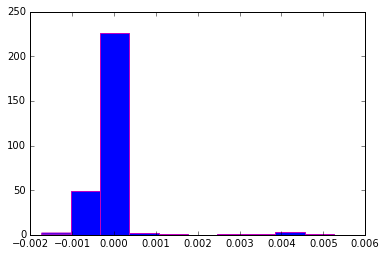

In [384]:
a=plt.hist(m_star['zhelio'],label='m_star',edgecolor='m')

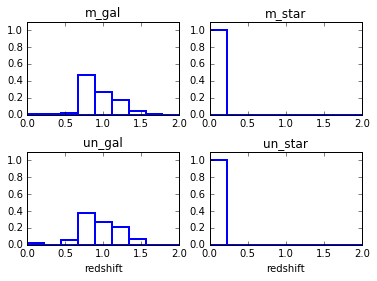

In [401]:
bins=np.linspace(0,2,10)
hdata={}
kwargs=dict(bins=bins,fill=False,normed=True,linewidth=2.)
hdata['m_gal']= plt.hist(m_gal['zhelio'],label='m_gal',edgecolor='b',**kwargs)
hdata['m_star']= plt.hist(m_star['zhelio'],label='m_star',edgecolor='m',**kwargs)
hdata['un_gal']= plt.hist(un_gal['zhelio'],label='un_gal',edgecolor='g',**kwargs)
hdata['un_star']= plt.hist(un_star['zhelio'],label='un_star',edgecolor='y',**kwargs)
plt.xlabel('redshift')
plt.legend(loc=(1.01,0))
plt.close()
#plot normalizing by total counts
fig,axes=plt.subplots(2,2)
ax=axes.flatten()
plt.subplots_adjust(hspace=0.4,wspace=0.2)
kwargs=dict(color='none',edgecolor='b',linewidth=2.,fill=False)
for cnt,key,c in zip(range(4),['m_gal','m_star','un_gal','un_star'],['b','m','g','y']):
    width= hdata[key][1][1:]-hdata[key][1][:-1]
    ax[cnt].bar(hdata[key][1][:-1],hdata[key][0]/hdata[key][0].sum(),width=width,**kwargs)
    ax[cnt].set_title(key)
for cnt in range(4):
    ax[cnt].set_ylim(0,1.1)
    if cnt >=2: ax[cnt].set_xlabel('redshift')
# plt.legend(loc=(1.01,0))

In [446]:
m_gal.keys()

['z_ext',
 'w2_ext',
 'besti',
 'gflux',
 'w1_ext',
 'zflux',
 'dr2_dec',
 'w1flux',
 'bestb',
 'g_ext',
 'w2flux',
 'dr2_ra',
 'r_ext',
 'bestr',
 'dp_dec',
 'type',
 'dp_ra',
 'rflux',
 'zhelio']

In [447]:
np.where(m_gal['bestr'] <=0 )[0].shape

(0,)

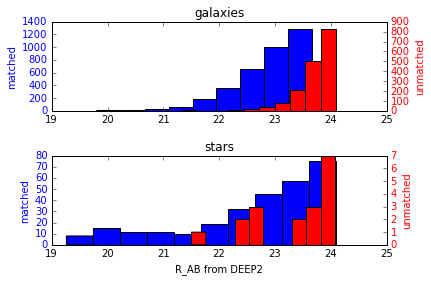

In [449]:
fig,ax=plt.subplots(2,1)
plt.subplots_adjust(wspace=0.5,hspace=0.5)
ax[0].hist(m_gal['bestr'],color='b')
ax[0].set_title('galaxies')
ax[0].set_ylabel('matched',color='b')
for tl in ax[0].get_yticklabels():
    tl.set_color('b')
#2nd y axis
ax2 = ax[0].twinx()
ax2.hist(un_gal['bestr'],color='r')
ax2.set_ylabel('unmatched', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
#2nd panel
ax[1].hist(m_star['bestr'],color='b')
ax[1].set_title('stars')
ax[1].set_ylabel('matched',color='b')
for tl in ax[1].get_yticklabels():
    tl.set_color('b')
#2nd y axis
ax2 = ax[1].twinx()
ax2.hist(un_star['bestr'],color='r')
ax2.set_ylabel('unmatched', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax[1].set_xlabel('R_AB from DEEP2')

In [557]:
a=None
a is not None

False

In [561]:
def hist_2yaxis(h1,h2,lab1=[],lab2=[],titles=[],fname=None):
    '''h1,h2 are lists of shape (2,N)
    lab1,lab2 are labels, lists of len 2'''
    assert(len(h1)==2)
    assert(len(h1)==len(h2))
    fig,ax=plt.subplots(2,1,figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.2)
    #formatting
    kwargs=dict(bar=dict(alpha=0.5),text=dict(fontsize=20)) 
    mpl.rcParams['xtick.labelsize'] = kwargs['text']['fontsize']-10
    mpl.rcParams['ytick.labelsize'] = kwargs['text']['fontsize']-10
    #
    ax[0].hist(h1[0],color='b',**kwargs['bar'])
    ax[0].set_title(titles[0],**kwargs['text'])
    ax[0].set_ylabel(lab1[0],color='b',**kwargs['text'])
    for tl in ax[0].get_yticklabels():
        tl.set_color('b')
    #2nd y axis
    ax2 = ax[0].twinx()
    ax2.hist(h1[1],color='r',**kwargs['bar'])
    ax2.set_ylabel(lab1[1], color='r',**kwargs['text'])
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    #2nd panel
    ax[1].hist(h2[0],color='b',**kwargs['bar'])
    ax[1].set_title(titles[1],**kwargs['text'])
    ax[1].set_ylabel(lab2[0],color='b',**kwargs['text'])
    for tl in ax[1].get_yticklabels():
        tl.set_color('b')
    #2nd y axis
    ax2 = ax[1].twinx()
    ax2.hist(h2[1],color='r',**kwargs['bar'])
    ax2.set_ylabel(lab2[1], color='r',**kwargs['text'])
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    #label
    ax[1].set_xlabel('R (AB)',**kwargs['text'])
    if fname is not None: plt.savefig(fname)

In [531]:
m_star['bestr'].min(),un_star['bestr'].min()

(19.2635, 21.506201)

/Users/kburleigh/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide
/Users/kburleigh/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


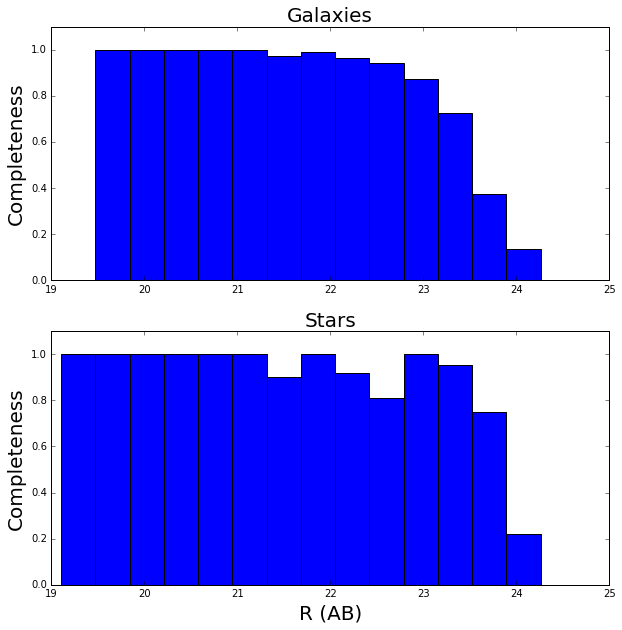

In [548]:
#same magnitude bins for detections
lo=int(min(m_gal['bestr'].min(),un_gal['bestr'].min(),m_star['bestr'].min(),un_star['bestr'].min()))-1
hi=int(max(m_gal['bestr'].max(),un_gal['bestr'].max(),m_star['bestr'].max(),un_star['bestr'].max()))+1
bins=np.linspace(lo,hi,20)
h={}
h['m_gal']= plt.hist(m_gal['bestr'],bins=bins)
h['un_gal']= plt.hist(un_gal['bestr'],bins=bins)
h['m_star']= plt.hist(m_star['bestr'],bins=bins)
h['un_star']= plt.hist(un_star['bestr'],bins=bins)
plt.close()
#plot normalizing by total counts
fig,ax=plt.subplots(2,1,figsize=(10,10))
plt.subplots_adjust(wspace=0.5,hspace=0.2)
kwargs=dict(bar=dict(color='b'), text=dict(fontsize=20)) #,edgecolor='b',linewidth=2.,fill=False)
mpl.rcParams['xtick.labelsize'] = kwargs['text']['fontsize']-10
mpl.rcParams['ytick.labelsize'] = kwargs['text']['fontsize']-10
#panel 1
width= h['m_gal'][1][1:]-h['m_gal'][1][:-1]
ax[0].bar(h['m_gal'][1][:-1],h['m_gal'][0]/(h['m_gal'][0]+h['un_gal'][0]),width=width,**kwargs['bar'])
ax[0].set_ylabel("Completeness",**kwargs['text'])
ax[0].set_title("Galaxies",**kwargs['text'])
#panel 2
ax[1].bar(h['m_star'][1][:-1],h['m_star'][0]/(h['m_star'][0]+h['un_star'][0]),width=width,**kwargs['bar'])
ax[1].set_ylabel("Completeness",**kwargs['text'])
ax[1].set_title("Stars",**kwargs['text'])
ax[1].set_xlabel("R (AB)",**kwargs['text'])
for i in range(2):
    ax[i].set_ylim(0,1.1)
plt.savefig("completeness.png")

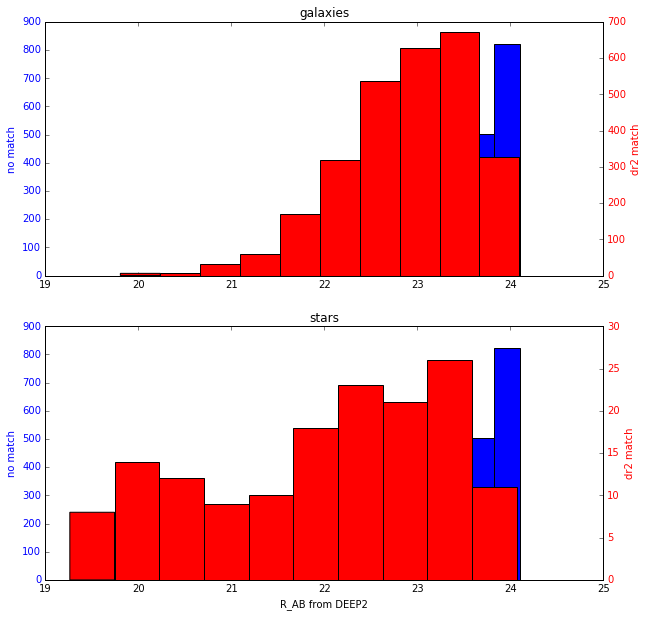

In [522]:
#turn into %complete histogram
h1=[un_gal['bestr'],m_gal['bestr']]
h2=[un_gal['bestr'],m_star['bestr']]
lab1=['no match','dr2 match']
titles=['galaxies','stars']
hist_2yaxis(h1,h2,lab1=lab1,lab2=lab1,titles=titles)

In [480]:
m_gal['bestr'].shape[0]

2757

True=Galaxy, FP/(TP+FP)=  0.457743924556
True=Star, FP/(TP+FP)=  0.105263157895


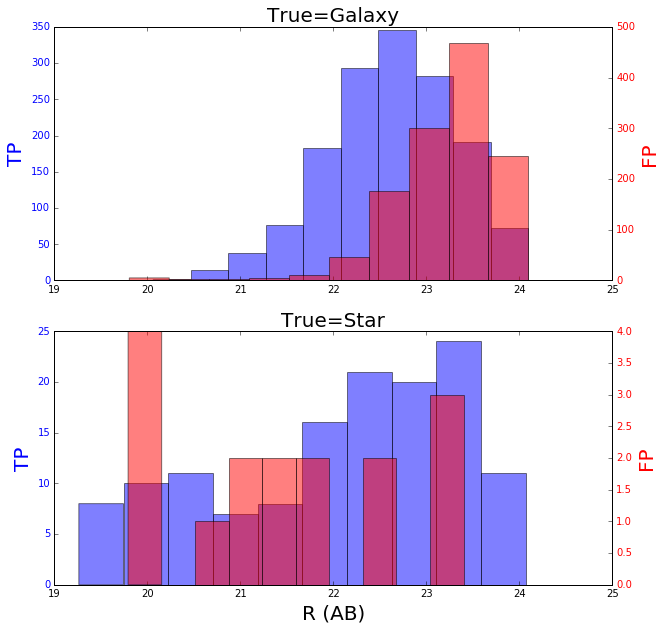

In [562]:
#This is encouraging, if galaxies are defined as "not PSF" we only mis classify 45% of them. 
#At our magnitude limit of r < 24, we would only expect to correctly classify galaxies ~ 50% of the time
#in addition, higher redshift galaxies are small so would be correctly labeled as "PSF" by Tractor
pred_psf= m_gal['type'] == ' PSF'
pred_gal= m_gal['type'] != ' PSF'
h1=[m_gal['bestr'][pred_gal],m_gal['bestr'][pred_psf]]
print 'True=Galaxy, FP/(TP+FP)= ',m_gal['bestr'][pred_psf].shape[0]/float(m_gal['bestr'].shape[0])
pred_psf= m_star['type'] == ' PSF'
pred_gal= m_star['type'] != ' PSF'
h2=[m_star['bestr'][pred_psf],m_star['bestr'][pred_gal]]
lab1=['TP','FP']
titles=['True=Galaxy','True=Star']
hist_2yaxis(h1,h2,lab1=lab1,lab2=lab1,titles=titles,fname='false_positive_type.png')
print 'True=Star, FP/(TP+FP)= ',m_star['bestr'][pred_gal].shape[0]/float(m_star['bestr'].shape[0])


In [518]:
get_targets(m_gal)
get_targets(m_star)

/Users/kburleigh/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2757 but corresponding boolean dimension is 152
  app.launch_new_instance()


In [516]:
m_gal['zhelio'].shape,m_gal['zhelio'][m_gal['non_ptsrc']].shape[0]+m_gal['zhelio'][m_gal['ptsrc']].shape[0]

((2757,), 2757)

In [519]:
m_star['zhelio'].shape,m_star['zhelio'][m_star['non_ptsrc']].shape[0]+m_star['zhelio'][m_star['ptsrc']].shape[0]

((152,), 152)

In [520]:
m_star['zhelio'].shape,m_star['zhelio'][m_star['non_ptsrc']].shape[0] #+m_star['zhelio'][m_star['ptsrc']].shape[0]

((152,), 1)

True=Galaxy, FP/(TP+FP)=  0.930721799057
True=Star, FP/(TP+FP)=  0.00657894736842


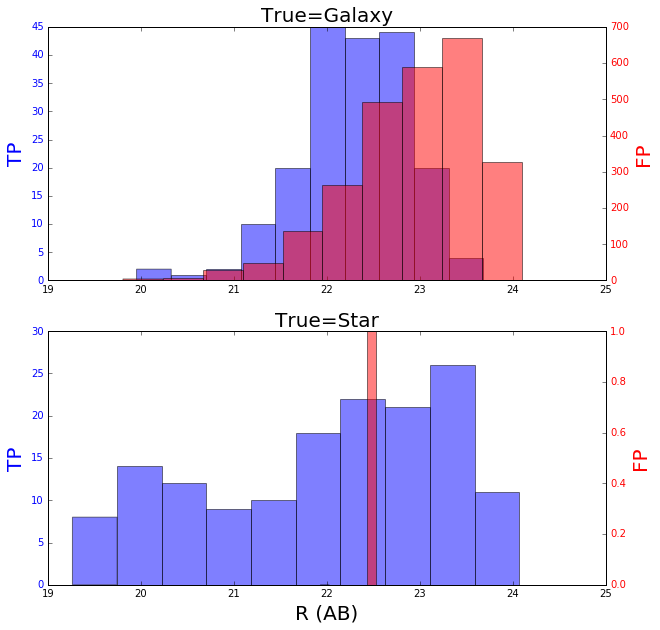

In [563]:
#this looks bad, only 7% of the DEEP2 galaxies are the types of galaxies we are looking for (ELG,LRG,QSO,BGS), 
#but it is okay because DEEP2 targetted galaxies based on cuts in B-R vs. R-I color space only
pred_psf= m_gal['ptsrc']
pred_gal= m_gal['non_ptsrc']
h1=[m_gal['bestr'][pred_gal],m_gal['bestr'][pred_psf]]
print 'True=Galaxy, FP/(TP+FP)= ',m_gal['bestr'][pred_psf].shape[0]/float(m_gal['bestr'].shape[0])
pred_psf= m_star['ptsrc']
pred_gal= m_star['non_ptsrc'] 
h2=[m_star['bestr'][pred_psf],m_star['bestr'][pred_gal]]
lab1=['TP','FP']
titles=['True=Galaxy','True=Star']
hist_2yaxis(h1,h2,lab1=lab1,lab2=lab1,titles=titles,fname='false_positive_color.png')
print 'True=Star, FP/(TP+FP)= ',m_star['bestr'][pred_gal].shape[0]/float(m_star['bestr'].shape[0])

In [ ]:
pred_psf= m_gal['type'] == ' PSF'
pred_gal= m_gal['type'] != ' PSF'
h1=[m_gal['bestr'][pred_gal],m_gal['bestr'][pred_psf]]
pred_psf= m_star['type'] == ' PSF'
pred_gal= m_star['type'] != ' PSF'
h2=[m_star['bestr'][pred_psf],m_star['bestr'][pred_gal]]
lab1=['TP','FP']
titles=['True=Galaxy','True=Star']
hist_2yaxis(h1,h2,lab1=lab1,lab2=lab1,titles=titles)

In [471]:
get_targets(m_gal)

In [477]:
np.where(m_gal['bgs'] == True)[0].shape

(1,)

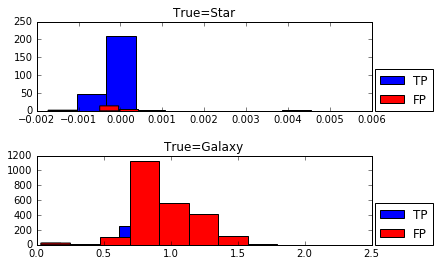

In [459]:
kwargs=dict(bins=10,fill=False,normed=True,linewidth=2.)

fig,ax=plt.subplots(2,1)
pred_psf= m_star['type'] == ' PSF'
pred_gal= m_star['type'] != ' PSF'
plt.subplots_adjust(wspace=0.5,hspace=0.5)
ax[0].set_title('True=Star')
ax[0].hist(m_star['zhelio'][pred_psf],color='b',label='TP')
ax[0].hist(m_star['zhelio'][pred_gal],color='r',label='FP')
##
pred_psf= m_gal['type'] == ' PSF'
pred_gal= m_gal['type'] != ' PSF'
ax[1].set_title('True=Galaxy')
ax[1].hist(m_gal['zhelio'][pred_gal],color='b',label='TP')
ax[1].hist(m_gal['zhelio'][pred_psf],color='r',label='FP')

for i in range(2): 
    ax[i].legend(loc=(1.01,0))


<Container object of 19 artists>

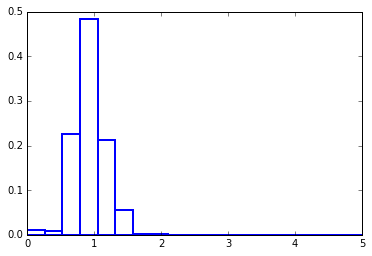

In [374]:
bins=np.linspace(0,2,10)
hdata={}
kwargs=dict(bins=bins,fill=False,normed=True,linewidth=2.)
hdata['m_gal']= plt.hist(m_gal['g'][m_gal['g']>0]) plt.hist(m_gal['zhelio'],label='m_gal',edgecolor='b',**kwargs)
hdata['m_star']= plt.hist(m_star['zhelio'],label='m_star',edgecolor='m',**kwargs)
hdata['un_gal']= plt.hist(un_gal['zhelio'],label='un_gal',edgecolor='g',**kwargs)
hdata['un_star']= plt.hist(un_star['zhelio'],label='un_star',edgecolor='y',**kwargs)
plt.xlabel('redshift')
plt.legend(loc=(1.01,0))
plt.close()
#plot normalizing by total counts
fig,axes=plt.subplots(2,2)
ax=axes.flatten()
plt.subplots_adjust(hspace=0.4,wspace=0.2)
kwargs=dict(color='none',edgecolor='b',linewidth=2.,fill=False)
for cnt,key,c in zip(range(4),['m_gal','m_star','un_gal','un_star'],['b','m','g','y']):
    width= hdata[key][1][1:]-hdata[key][1][:-1]
    ax[cnt].bar(hdata[key][1][:-1],hdata[key][0]/hdata[key][0].sum(),width=width,**kwargs)
    ax[cnt].set_title(key)
for cnt in range(4):
    ax[cnt].set_ylim(0,1.1)
    if cnt >=2: ax[cnt].set_xlabel('redshift')
# plt.legend(loc=(1.01,0))

In [423]:
m_gal.keys()

['g_ext',
 'w1mag',
 'zflux_ext',
 'zmag',
 'lrg',
 'w2mag',
 'elg',
 'w1flux_ext',
 'bgs',
 'w2flux_ext',
 'r_ext',
 'type',
 'rflux',
 'zhelio',
 'zflux',
 'w1flux',
 'qso',
 'w2flux',
 'g',
 'rmag',
 'gmag',
 'w2_ext',
 'dp_dec',
 'dp_ra',
 'rflux_ext',
 'gflux',
 'dr2_dec',
 'w1_ext',
 'gflux_ext',
 'dr2_ra',
 'r',
 'z',
 'z_ext']

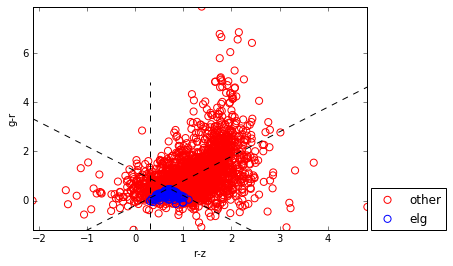

In [427]:
get_targets(m_gal)
x=m_gal['rmag']-m_gal['zmag']
y=m_gal['gmag']-m_gal['rmag']
# ['bgs','lrg','elg','qso']
plt.scatter(x,y,s=50,marker='o',facecolors='none',edgecolors='r',label='other')
ind= m_gal['elg']
plt.scatter(x[ind],y[ind],s=50,marker='o',facecolors='none',edgecolors='b',label='elg')
#cut lines
x2=np.linspace(x.min(),x.max())
plt.plot(x2,1.0*x2-0.2,'k--')
plt.plot(x2,-1.0*x2+1.2,'k--')
plt.plot([0.3]*len(x2),x2,'k--')
#
plt.ylabel('r-z')
plt.xlabel('g-r')
plt.xlim(x.min(),x.max())
plt.ylim(y.min(),y.max())
plt.legend(loc=(1.01,0),scatterpoints=1)

ValueError: x and y must have same first dimension

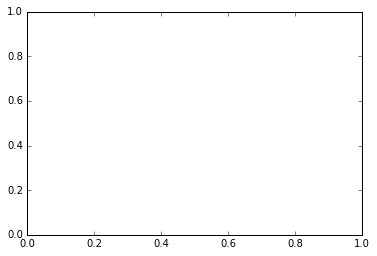

In [300]:
line1=1.0*x2-0.2
line2=-1.0*x2+1.2
ind=np.logical_and(line1 <= line2,line2< line1)
plt.plot(x2,line1[ind])
plt.plot(x2,line2[ind])

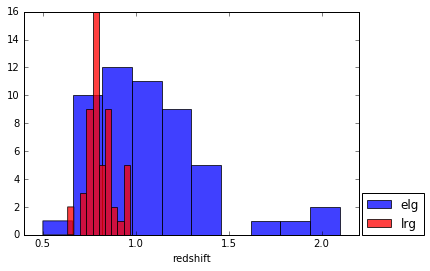

In [293]:
for key,c in zip(['elg','lrg','bgs','qso'],\
                 ['b','r','g','y']):
    bins= dat['zhelio'][dat[key]].shape[0]/5
    if bins > 0:
        plt.hist(dat['zhelio'][dat[key]],bins=bins,color=c,alpha=0.75,label=key)
# plt.hist(dat['zhelio'][dat['lrg']],bins=10,color=c,label='lrg')
# plt.hist(dat['zhelio'][dat['bgs']],bins=10,color=c,label='bgs')
# plt.hist(dat['zhelio'][dat['qso']],bins=10,color=c,label='qso')
plt.xlabel('redshift')
plt.legend(loc=(1.01,0))

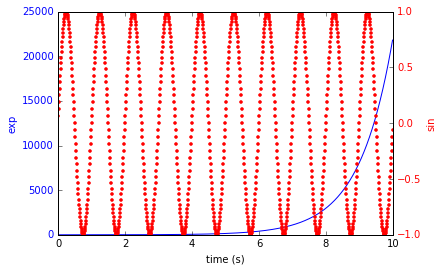

In [428]:
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

In [48]:
from modules.plot.multi_panels import multi_plot

In [59]:
def row_col_plot(nrow,ncol,x,y,scatter=False,indices=None,fname='test.png',titles=None,xlim=False,ylim=False,logx=False,logy=False):
    '''x,y have shape (nrow*ncol,values,extra_axis)
    extra_axis is not necessary if plotting single line per plot otherwise extra axis 
    contains those lines'''
    assert(nrow == 1 or ncol == 1)
    assert(x.shape[0] == nrow*ncol)
    w,h=20,10
    fig,axes=plt.subplots(nrow,ncol,figsize=(w,h))
    ax=axes.flatten()
    plt.subplots_adjust(hspace=0,wspace=0)
    cnt=0
    for i in range(len(ax)):
        if len(x.shape) == 3: #exta_axis, multiple lines per plot
            for extra in range(x.shape[2]):
                #some values may be nan or inf if some lines longer than others
                iuse= np.isfinite(x[cnt,:,extra])
                if scatter: ax[i].scatter(x[cnt,iuse,extra],y[cnt,iuse,extra])
                else: ax[i].plot(x[cnt,iuse,extra],y[cnt,iuse,extra])
        else: 
            if scatter: ax[i].scatter(x[cnt,:],y[cnt,:])
            else: ax[i].plot(x[cnt,:],y[cnt,:])
        if titles is not None: ax[i].set_title('%s' % titles[cnt])
        cnt+=1
    for i in range(len(ax)):
        if xlim: ax[i].set_xlim(xlim[0],xlim[1])
        if ylim: ax[i].set_ylim(ylim[0],ylim[1])
        if logx: ax[i].set_xscale('log')
        if logy: ax[i].set_yscale('log')
#     for i in range(len(ax)):
#         if r != range(nrow)[-1]: ax[i].xaxis.set_major_formatter(plt.NullFormatter())
#         if c != 0: ax[i].yaxis.set_major_formatter(plt.NullFormatter())
#     plt.savefig(fname)
#     plt.close()

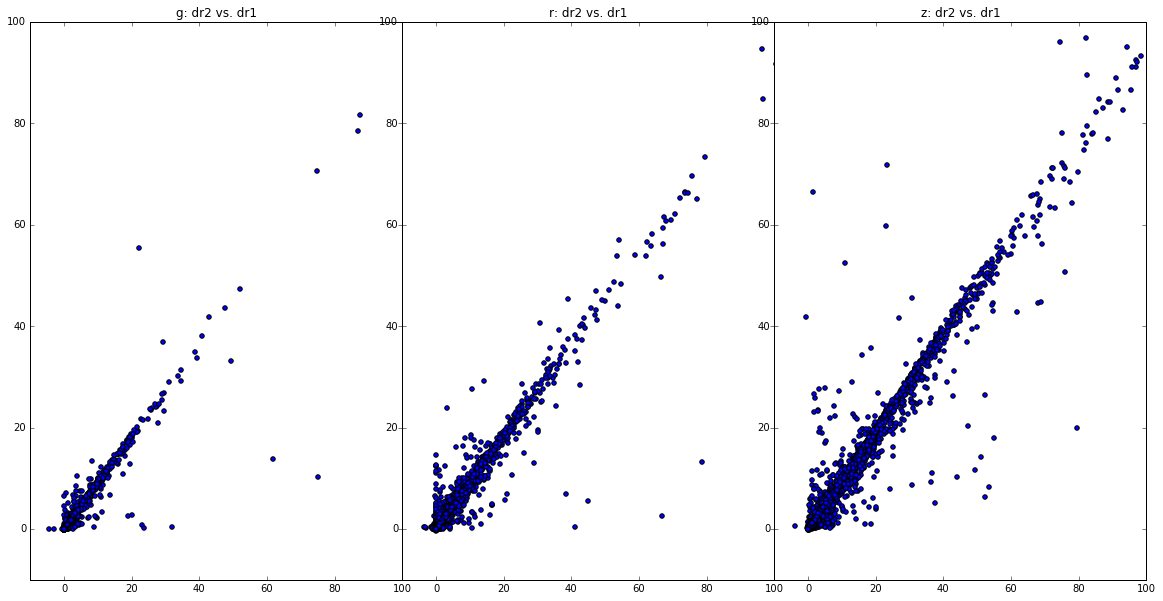

In [62]:
x=np.zeros( (3,len(data['dr1_gflux']),2) )
y=x.copy()
for i,dr1,dr2 in zip(range(3),
                     ['dr1_gflux', 'dr1_rflux', 'dr1_zflux'],
                    ['dr2_gflux', 'dr2_rflux', 'dr2_zflux']):
    x[i,:,0]= data[dr1]
#     x[i,:,1]= data[dr1] #drawing straight line
    y[i,:,0]= data[dr2]
#     y[i,:,1]= x[i,:,1]
titles=['%s: dr2 vs. dr1' % b for b in ['g','r','z']]
row_col_plot(1,3,x,y,titles=titles,scatter=True,ylim=[-10,100],xlim=[-10,100])

(array([  5.00000000e+00,   2.80000000e+01,   1.87000000e+02,
          6.98000000e+02,   1.62600000e+03,   3.21600000e+03,
          5.35400000e+03,   5.32100000e+03,   6.88000000e+02,
          1.70000000e+01]),
 array([  5.51035528,   8.06474453,  10.61913378,  13.17352303,
         15.72791228,  18.28230153,  20.83669078,  23.39108003,
         25.94546928,  28.49985853,  31.05424778]),
 <a list of 10 Patch objects>)

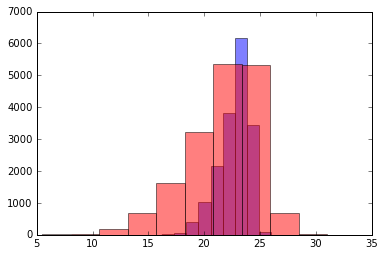

In [84]:
plt.hist(data['mag_isocor'],color='b',alpha=0.5)
mags= -2.5*np.log(data['dr1_zflux'][ data['dr1_zflux'] > 0 ])
plt.hist(mags+22.5,color='r',alpha=0.5)

(array([    7.,    40.,   211.,   707.,  1779.,  4467.,  6879.,  2139.,
          561.,    47.]),
 array([ 16.93814952,  18.08892264,  19.23969576,  20.39046887,
         21.54124199,  22.69201511,  23.84278822,  24.99356134,
         26.14433446,  27.29510757,  28.44588069]),
 <a list of 10 Patch objects>)

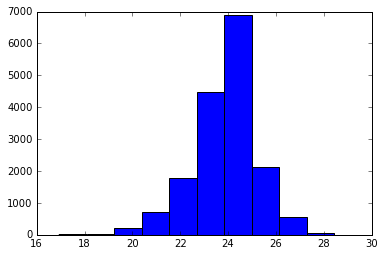

In [82]:
# plt.hist( flux_to_mag(data['dr1_gflux']))
mags= -2.5*np.log10(data['dr1_gflux'][ data['dr1_gflux'] > 0 ])
plt.hist(mags+22.5)

(array([  5.00000000e+00,   2.80000000e+01,   1.87000000e+02,
          6.98000000e+02,   1.62600000e+03,   3.21600000e+03,
          5.35400000e+03,   5.32100000e+03,   6.88000000e+02,
          1.70000000e+01]),
 array([-16.98964472, -14.43525547, -11.88086622,  -9.32647697,
         -6.77208772,  -4.21769847,  -1.66330922,   0.89108003,
          3.44546928,   5.99985853,   8.55424778]),
 <a list of 10 Patch objects>)

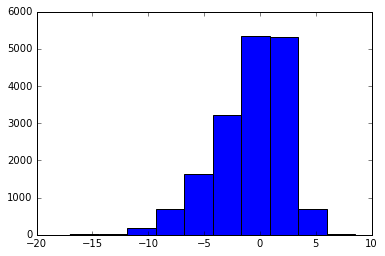

In [81]:
mags= -2.5*np.log(data['dr1_zflux'][ data['dr1_zflux'] > 0 ])
plt.hist(mags)

In [80]:
-2.5*np.log(1e-3)

17.269388197455342

In [86]:
bashCommand = "date"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output = process.communicate()[0]
output

'Wed Feb 17 15:42:33 PST 2016\n'

In [99]:
a='deep2_f2'
a.startswith('deep2')

True

In [98]:
output[output.find(':')-2:].replace(' ','').strip().replace(':','-')

'15-42-33PST2016'

In [91]:
output[13:]

':42:33 PST 2016\n'